## Assignment 2

In [1]:
import torch
torch.__version__

'0.2.0_4'

### Importing, normalizing and bootstrapping data

We are loading the data from `npz` numpy zip, splitting the training in train and validation sets and parsing those to tensor datasets for training pytorch models  

**TODO**: Bootstrap

In [46]:
import numpy as np
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

data_set = np.load('./prediction-challenge-01-data.npz')

X, y, test_x = data_set['data_x'], data_set['data_y'], data_set['test_x']

#### Let's try some bootstrapping

In [3]:
from scipy import ndimage
import matplotlib.pyplot as plt

plt.imshow(ndimage.rotate(X[0][0], 65, reshape=False), cmap='gray')

In [4]:
train_x, validation_x, train_y, validation_y = train_test_split(X, y, test_size=.2)

mean_image = np.mean(train_x, axis=0)
train_x -= mean_image
validation_x -= mean_image
test -= mean_image

print(X.shape)
print(y.shape)

(20000, 1, 28, 28)
(20000,)


### Rotate

Let's rotate the images a little bit in order to gain some more training data

In [ ]:
new_x = train_x
new_y = train_y
for deg in range(15, 61, 15):
    new_data = []
    new_labels = y
    for i, x in enumerate(X):
        new_data.append([ndimage.rotate(x[0], 65, reshape=False)])
        
    new_x = np.vstack([new_x, new_data])
    new_y = np.append(new_y, new_labels)
train_x = new_x
train_y = new_y

In [5]:
train_dataset = data_utils.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_dataset = data_utils.TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))

# to make sure everything is fine
print('Shape of training data: {}'.format(train_x.shape))
print('Labels\' shape: {}'.format(train_y.shape))

Shape of training data: (16000, 1, 28, 28)
Labels' shape: (16000,)


### Visualizing data

It's always good to know how our data looks like and what the corresponding labels are

5

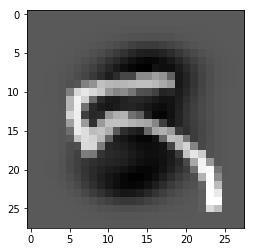

In [6]:
%matplotlib inline

plt.imshow(train_x[0][0], cmap='gray')
train_y[0]

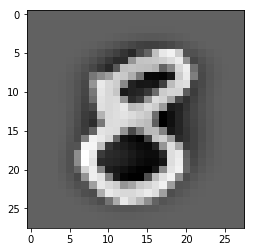

In [7]:
plt.imshow((validation_x)[0][0], cmap='gray')

### Mean Image

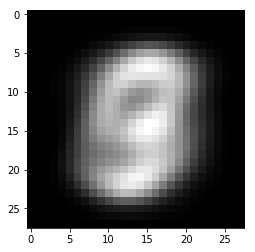

In [9]:
plt.imshow(mean_image[0], cmap='gray')

### Model

#### VGG

As done in "Mustererkennung" course in WS17, we used VGG, though not VGG11

We are using the VGG nets model. This is a pretty famous model and works great for recognizing images. Basic principle is to have some convolutional layers followed by pooling layers, the whole thing multiple times. Afterwards one usually has some number of fully connected layers, though this is originally not so in VGG. We decided to add the fully connected layers anyways, as we don't have the capcaity to run the original VGG model anyways.

Further info -> http://www.robots.ox.ac.uk/~vgg/research/very_deep/

#### Batchnorm, Dropout, Xavier

Bachnorm makes training a model quicker as it keeps mean and standart deviation consistant within the network (if the model decides it's helpful for it, how much batch normalisation is used is a learning parameter). Dropout makes sure the NN doesn't overfit, as it repeatedly temporarily disables some neurons so better generalisation is reached. Xavier is used for better weights initialisation.

#### First implementation

Score 99.2%; No FC layers, 0.005 learning rate

In [20]:
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    'VGG': [16, 32, 'M', 64, 64, 'M', 128, 128, 'M', 128, 128, 'M']
}

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv_layers, self.fc_layers = self._make_layers(cfg['VGG'])
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        
        # allow for no FC
        if (len(self.fc_layers) > 0):
            x = x.view(x.size(0), x.size(1))
            x = self.fc_layers(x)

        x = x.view(x.size(0), -1)
        return self.classifier(x)
    
    def _make_layers(self, cfg):
        conv_layers = []
        fc_layers = []
        in_channels = 1
        build_fc = False
        
        for x in cfg:
            if build_fc:
                fc = nn.Linear(in_channels, x)
                fc_layers += [fc,
                           nn.BatchNorm1d(x),
                           nn.ReLU(inplace=True)]
                nn.init.xavier_uniform(fc.weight)
            elif x == 'M':
                conv_layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif x == 'FC':
                build_fc = True
            else:
                conv = nn.Conv2d(in_channels, x, kernel_size=3, padding=1)
                conv_layers += [conv,
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                nn.init.xavier_uniform(conv.weight)
                
            if isinstance(x, int):
                in_channels = x
        conv_layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
            
        return nn.Sequential(*conv_layers), nn.Sequential(*fc_layers)

In [21]:
model = VGG()
if torch.cuda.is_available():
    model.cuda()

In [22]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [23]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 16}
print('num_workers={}'.format(kwargs['num_workers']))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

num_workers=16


In [24]:
from torch.autograd import Variable

def train(epoch, callback):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        optimizer.step()
        
        callback(batch_idx, output, target)
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data[0]))

In [44]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset), test_loss

### Prepare for plotting

In [26]:
def save_accuracy(i, output, target, save_in):
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.data.view_as(pred)).cpu().sum()
    save_in.append(100. * correct / len(output))
    
def get_save_acc_in(save_in):
    return lambda x, y, z: save_accuracy(x, y, z, save_in)

In [27]:
%%time

per_batch_acc = []
epoch_acc = []
val_losses = []
best_acc = 0

# max 200 epochs, we are going to stop training when validation score gets worse
for epoch in range(1, 200 + 1):
    train(epoch, get_save_acc_in(per_batch_acc))
    accuracy, val_loss = test()
    epoch_acc.append(accuracy)
    val_losses.append(val_loss)
    
    if best_acc < accuracy:
        best_acc = accuracy
        torch.save(model.state_dict(), './model_final')
    else:
        break

Train Epoch: 1 [128/16000 (1%)]	Loss: 2.372820
Train Epoch: 1 [256/16000 (2%)]	Loss: 2.519730
Train Epoch: 1 [384/16000 (2%)]	Loss: 2.392068
Train Epoch: 1 [512/16000 (3%)]	Loss: 2.003712
Train Epoch: 1 [640/16000 (4%)]	Loss: 1.940548
Train Epoch: 1 [768/16000 (5%)]	Loss: 1.877185
Train Epoch: 1 [896/16000 (6%)]	Loss: 1.720561
Train Epoch: 1 [1024/16000 (6%)]	Loss: 1.524794
Train Epoch: 1 [1152/16000 (7%)]	Loss: 1.521416
Train Epoch: 1 [1280/16000 (8%)]	Loss: 1.328659
Train Epoch: 1 [1408/16000 (9%)]	Loss: 1.263511
Train Epoch: 1 [1536/16000 (10%)]	Loss: 1.055648
Train Epoch: 1 [1664/16000 (10%)]	Loss: 1.048292
Train Epoch: 1 [1792/16000 (11%)]	Loss: 0.981282
Train Epoch: 1 [1920/16000 (12%)]	Loss: 0.894886
Train Epoch: 1 [2048/16000 (13%)]	Loss: 0.788530
Train Epoch: 1 [2176/16000 (14%)]	Loss: 0.627101
Train Epoch: 1 [2304/16000 (14%)]	Loss: 0.677232
Train Epoch: 1 [2432/16000 (15%)]	Loss: 0.668166
Train Epoch: 1 [2560/16000 (16%)]	Loss: 0.572509
Train Epoch: 1 [2688/16000 (17%)]	Loss

Train Epoch: 2 [5376/16000 (34%)]	Loss: 0.171814
Train Epoch: 2 [5504/16000 (34%)]	Loss: 0.172364
Train Epoch: 2 [5632/16000 (35%)]	Loss: 0.137208
Train Epoch: 2 [5760/16000 (36%)]	Loss: 0.075705
Train Epoch: 2 [5888/16000 (37%)]	Loss: 0.094368
Train Epoch: 2 [6016/16000 (38%)]	Loss: 0.085913
Train Epoch: 2 [6144/16000 (38%)]	Loss: 0.057605
Train Epoch: 2 [6272/16000 (39%)]	Loss: 0.053945
Train Epoch: 2 [6400/16000 (40%)]	Loss: 0.094718
Train Epoch: 2 [6528/16000 (41%)]	Loss: 0.068497
Train Epoch: 2 [6656/16000 (42%)]	Loss: 0.110919
Train Epoch: 2 [6784/16000 (42%)]	Loss: 0.103406
Train Epoch: 2 [6912/16000 (43%)]	Loss: 0.043269
Train Epoch: 2 [7040/16000 (44%)]	Loss: 0.129257
Train Epoch: 2 [7168/16000 (45%)]	Loss: 0.102471
Train Epoch: 2 [7296/16000 (46%)]	Loss: 0.094840
Train Epoch: 2 [7424/16000 (46%)]	Loss: 0.066039
Train Epoch: 2 [7552/16000 (47%)]	Loss: 0.065311
Train Epoch: 2 [7680/16000 (48%)]	Loss: 0.095285
Train Epoch: 2 [7808/16000 (49%)]	Loss: 0.049202
Train Epoch: 2 [7936

Train Epoch: 3 [10624/16000 (66%)]	Loss: 0.019211
Train Epoch: 3 [10752/16000 (67%)]	Loss: 0.035296
Train Epoch: 3 [10880/16000 (68%)]	Loss: 0.151893
Train Epoch: 3 [11008/16000 (69%)]	Loss: 0.013276
Train Epoch: 3 [11136/16000 (70%)]	Loss: 0.021928
Train Epoch: 3 [11264/16000 (70%)]	Loss: 0.082638
Train Epoch: 3 [11392/16000 (71%)]	Loss: 0.015543
Train Epoch: 3 [11520/16000 (72%)]	Loss: 0.034050
Train Epoch: 3 [11648/16000 (73%)]	Loss: 0.021545
Train Epoch: 3 [11776/16000 (74%)]	Loss: 0.120240
Train Epoch: 3 [11904/16000 (74%)]	Loss: 0.008824
Train Epoch: 3 [12032/16000 (75%)]	Loss: 0.177029
Train Epoch: 3 [12160/16000 (76%)]	Loss: 0.026438
Train Epoch: 3 [12288/16000 (77%)]	Loss: 0.021786
Train Epoch: 3 [12416/16000 (78%)]	Loss: 0.025242
Train Epoch: 3 [12544/16000 (78%)]	Loss: 0.048206
Train Epoch: 3 [12672/16000 (79%)]	Loss: 0.082530
Train Epoch: 3 [12800/16000 (80%)]	Loss: 0.013871
Train Epoch: 3 [12928/16000 (81%)]	Loss: 0.040229
Train Epoch: 3 [13056/16000 (82%)]	Loss: 0.144162


Train Epoch: 4 [15744/16000 (98%)]	Loss: 0.073592
Train Epoch: 4 [15872/16000 (99%)]	Loss: 0.006712
Train Epoch: 4 [16000/16000 (100%)]	Loss: 0.013681

Test set: Average loss: 0.0732, Accuracy: 3913/4000 (97.825%)

Train Epoch: 5 [128/16000 (1%)]	Loss: 0.053290
Train Epoch: 5 [256/16000 (2%)]	Loss: 0.031334
Train Epoch: 5 [384/16000 (2%)]	Loss: 0.022712
Train Epoch: 5 [512/16000 (3%)]	Loss: 0.048133
Train Epoch: 5 [640/16000 (4%)]	Loss: 0.018626
Train Epoch: 5 [768/16000 (5%)]	Loss: 0.044199
Train Epoch: 5 [896/16000 (6%)]	Loss: 0.035639
Train Epoch: 5 [1024/16000 (6%)]	Loss: 0.036005
Train Epoch: 5 [1152/16000 (7%)]	Loss: 0.021623
Train Epoch: 5 [1280/16000 (8%)]	Loss: 0.015772
Train Epoch: 5 [1408/16000 (9%)]	Loss: 0.038737
Train Epoch: 5 [1536/16000 (10%)]	Loss: 0.032194
Train Epoch: 5 [1664/16000 (10%)]	Loss: 0.050878
Train Epoch: 5 [1792/16000 (11%)]	Loss: 0.013319
Train Epoch: 5 [1920/16000 (12%)]	Loss: 0.056046
Train Epoch: 5 [2048/16000 (13%)]	Loss: 0.017618
Train Epoch: 5 [217

Train Epoch: 6 [4864/16000 (30%)]	Loss: 0.056891
Train Epoch: 6 [4992/16000 (31%)]	Loss: 0.010801
Train Epoch: 6 [5120/16000 (32%)]	Loss: 0.009034
Train Epoch: 6 [5248/16000 (33%)]	Loss: 0.030747
Train Epoch: 6 [5376/16000 (34%)]	Loss: 0.010234
Train Epoch: 6 [5504/16000 (34%)]	Loss: 0.017382
Train Epoch: 6 [5632/16000 (35%)]	Loss: 0.007261
Train Epoch: 6 [5760/16000 (36%)]	Loss: 0.063406
Train Epoch: 6 [5888/16000 (37%)]	Loss: 0.013055
Train Epoch: 6 [6016/16000 (38%)]	Loss: 0.014087
Train Epoch: 6 [6144/16000 (38%)]	Loss: 0.023150
Train Epoch: 6 [6272/16000 (39%)]	Loss: 0.005522
Train Epoch: 6 [6400/16000 (40%)]	Loss: 0.013550
Train Epoch: 6 [6528/16000 (41%)]	Loss: 0.042648
Train Epoch: 6 [6656/16000 (42%)]	Loss: 0.003179
Train Epoch: 6 [6784/16000 (42%)]	Loss: 0.001832
Train Epoch: 6 [6912/16000 (43%)]	Loss: 0.010081
Train Epoch: 6 [7040/16000 (44%)]	Loss: 0.045648
Train Epoch: 6 [7168/16000 (45%)]	Loss: 0.008638
Train Epoch: 6 [7296/16000 (46%)]	Loss: 0.029491
Train Epoch: 6 [7424

In [29]:
def plot_accuracy(accuracy_arr, title, xlabel='Number of batches seen'):
    ax = plt.gca()
    ax.plot(np.arange(len(accuracy_arr)), accuracy_arr)
    # could be more than the total number of batches because of epochs
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(np.arange(len(accuracy_arr)))
    plt.title(title)
    plt.show()
    np.arange(len(accuracy_arr))

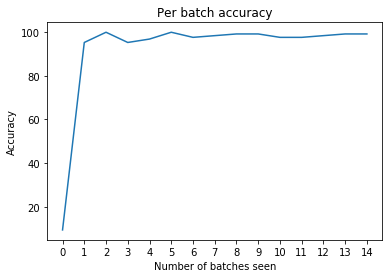

In [30]:
plot_accuracy(per_batch_acc[::50], 'Per batch accuracy')

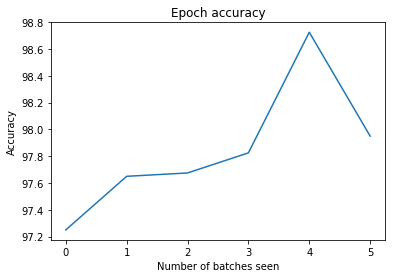

In [32]:
plot_accuracy(epoch_acc, 'Epoch accuracy')

In [42]:
model = VGG()
model.load_state_dict(torch.load('./model_final'))

In [43]:
test()


Test set: Average loss: 0.0368, Accuracy: 3958/4000 (98.950%)



(98.95, 0.03684121347684413)

### Prediction for challenge

In [49]:
 out = model(Variable(torch.from_numpy(test_x)))
_, prediction = torch.max(out, 1)
prediction = prediction.data.numpy()

9


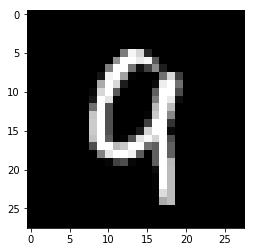

In [50]:
plt.imshow((test_x)[873][0], cmap='gray')
print(prediction[873])

5


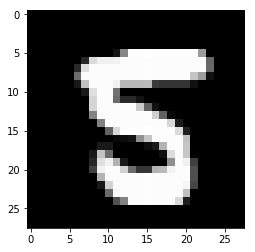

In [51]:
plt.imshow((test_x)[164][0], cmap='gray')
print(prediction[164])

3


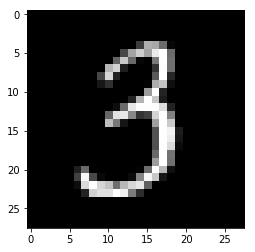

In [52]:
plt.imshow((test_x)[129][0], cmap='gray')
print(prediction[129])

In [53]:
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save("./prediction.npy", prediction)